In [1]:
from model.dataloader import NinaProDatasetLoader, NearlabDatasetLoader
from model.nina_helper import *
import torch
import pandas as pd
from sklearn.utils import shuffle
from scipy import signal
from model.utils import list_files

In [3]:
from model.model import CNet2D
version="Softmax"
folder_path = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/ninapro/DB2/person1/"

ninapro = NinaProDatasetLoader(folder_path, 1, 2, 512, 128)

X_train, y_train, X_test, y_test = ninapro.load_data(split_method="balanced", test_reps=2)

current_model = CNet2D(version=version, epochs=1, num_classes=50, batch_size=128, dataset_type="NinaPro")
history = current_model.fit(X_train, y_train)


Shape of EMG data: (5238693, 12)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x49152 and 25600x300)

In [7]:
path_nearlab = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/nearlab/8features/person1"
file_paths_nearlab = list_files(path_nearlab, "csv")
version = "GMLVQ"
data = NearlabDatasetLoader(file_paths_nearlab[:2], file_paths_nearlab[2:])
X_train, y_train, X_test, y_test = data.load_data(split_method="repetition_wise")

current_model = CNet2D(version=version, epochs=1, batch_size=128)
history = current_model.fit(X_train, y_train)


Epoch 1/1, Loss: 0.4865


In [2]:
folder_path = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/ninapro/DB2/person1/"

ninapro = NinaProDatasetLoader(folder_path, 1, 2, 400, 40)

X_train, y_train, X_test, y_test = ninapro.load_data(split_method="balanced", test_reps=2)

print(X_train.shape)

torch.Size([88272, 12, 400])


In [6]:
path_nearlab = "/Users/dennisschielke/Desktop/Uni/Bachelor_Thesis/src/data/nearlab/8features/person1"
file_paths_nearlab = list_files(path_nearlab, "csv")
version = "Softmax"
data = NearlabDatasetLoader(file_paths_nearlab[:2], file_paths_nearlab[2:])
X_train, y_train, X_test, y_test = data.load_data(split_method="file_split")
current_model = CNet2D(version=version, epochs=1, batch_size=128)
current_model.fit(X_train, y_train)

print(X_train.shape)

Epoch 1/1, Loss: 0.9053
torch.Size([5273, 10, 512])


Test Accuracy: 0.7028


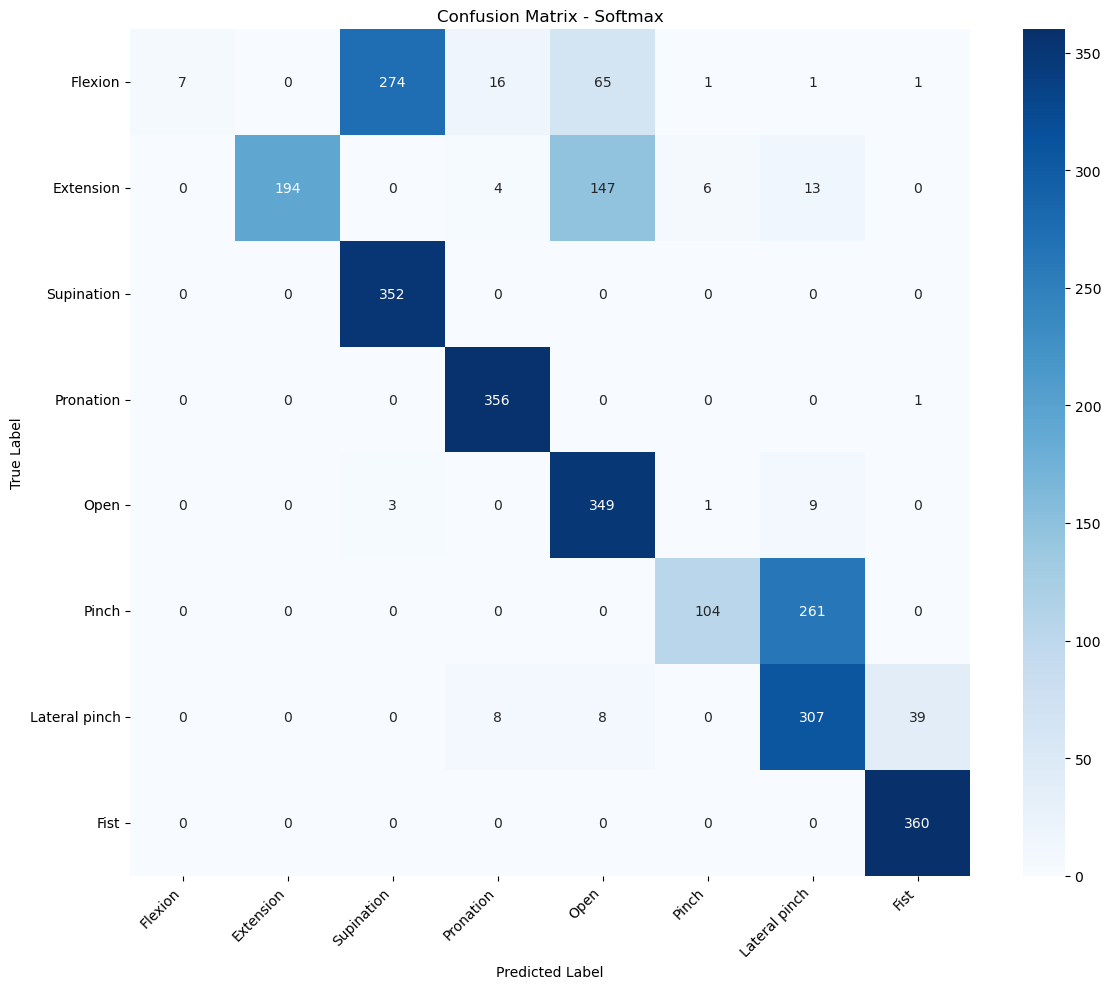


Classification Report:
               precision    recall  f1-score   support

      Flexion       1.00      0.02      0.04       365
    Extension       1.00      0.53      0.70       364
   Supination       0.56      1.00      0.72       352
    Pronation       0.93      1.00      0.96       357
         Open       0.61      0.96      0.75       362
        Pinch       0.93      0.28      0.44       365
Lateral pinch       0.52      0.85      0.64       362
         Fist       0.90      1.00      0.95       360

     accuracy                           0.70      2887
    macro avg       0.81      0.71      0.65      2887
 weighted avg       0.81      0.70      0.65      2887


Per-class Accuracy:
Flexion: 0.0192
Extension: 0.5330
Supination: 1.0000
Pronation: 0.9972
Open: 0.9641
Pinch: 0.2849
Lateral pinch: 0.8481
Fist: 1.0000


{'accuracy': 0.7028056979179382,
 'confusion_matrix': array([[  7,   0, 274,  16,  65,   1,   1,   1],
        [  0, 194,   0,   4, 147,   6,  13,   0],
        [  0,   0, 352,   0,   0,   0,   0,   0],
        [  0,   0,   0, 356,   0,   0,   0,   1],
        [  0,   0,   3,   0, 349,   1,   9,   0],
        [  0,   0,   0,   0,   0, 104, 261,   0],
        [  0,   0,   0,   8,   8,   0, 307,  39],
        [  0,   0,   0,   0,   0,   0,   0, 360]]),
 'per_class_accuracy': array([0.01917808, 0.53296703, 1.        , 0.99719888, 0.9640884 ,
        0.28493151, 0.8480663 , 1.        ]),
 'predictions': [6,
  6,
  3,
  1,
  6,
  7,
  7,
  4,
  6,
  4,
  7,
  2,
  2,
  3,
  4,
  2,
  6,
  7,
  7,
  5,
  7,
  6,
  3,
  2,
  7,
  6,
  3,
  6,
  2,
  6,
  4,
  7,
  5,
  7,
  2,
  7,
  6,
  4,
  2,
  5,
  5,
  1,
  4,
  7,
  2,
  6,
  2,
  2,
  4,
  2,
  1,
  6,
  4,
  4,
  4,
  4,
  3,
  3,
  4,
  6,
  4,
  1,
  7,
  4,
  7,
  3,
  2,
  7,
  6,
  4,
  6,
  4,
  3,
  4,
  1,
  1,
  2,
  2,
  6,

In [7]:
current_model.evaluate_model(X_test, y_test)